In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Update the dataset incase it has changed.
! cd ../input; ./update-dataset.sh >/dev/null

# Clean the input directory structure.
! rm -rf cmp23 preprocessed features
! mkdir -p {cmp23,preprocessed}/{fe,}male features

# Self explanatory.
! cp ../input/cmp23-handwritten-males-vs-females/Males/Males/* cmp23/male
! cp ../input/cmp23-handwritten-males-vs-females/Females/Females/* cmp23/female

# Rename all the dataset files to simple names.
! function rename { for path in "$@"; do cd $path; c=1; for file in $(/bin/ls); do /bin/mv $file $(printf "%03d" $c).jpg; let c=c+1; done; cd - >/dev/null; done; }; rename cmp23/{fe,}male

# Check the directory tree.
! tree --filelimit 100

zsh:1: no such file or directory: ./update-dataset.sh
.
├── cmp23
│   ├── female [131 entries exceeds filelimit, not opening dir]
│   └── male [232 entries exceeds filelimit, not opening dir]
├── features
├── features.py
├── helpers.py
├── malassifier.ipynb
├── preprocessed
│   ├── female
│   └── male
├── processing.py
└── utils.py

7 directories, 5 files
CPU times: user 22.7 ms, sys: 15.3 ms, total: 37.9 ms
Wall time: 2.42 s


In [2]:
# Imports.
from processing import *
from features import *
from helpers import *
from utils import *

In [3]:
# Constants.
ALL_IMAGES = get_all_images()
LABELS = load_labels()

TST_IMAGES = [
    cmp('female', 9),
    cmp('male', 67),
    cmp('male', 89),
    cmp('female', 3),
    cmp('male', 12),
    cmp('female', 4),
] # Some images' paths used oberservation.

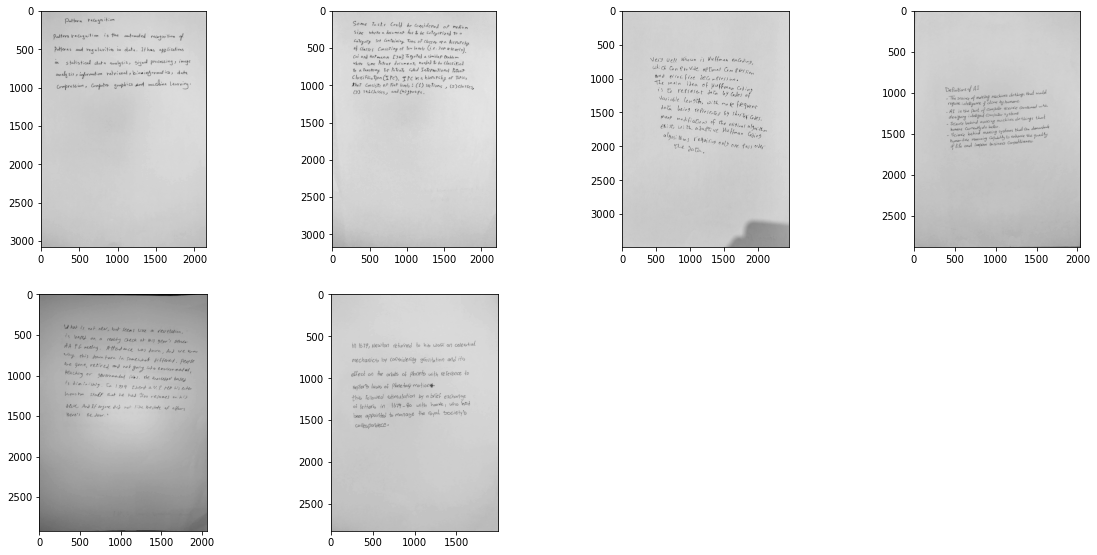

In [4]:
# Preview the test images before preprocessing them.
preview(TST_IMAGES)

In [5]:
%%time
# Preprocess the images and write them to the disk.
for image_path in ALL_IMAGES:
    imwrite(pre(image_path), preprocess(image_path))

CPU times: user 3min 2s, sys: 4.22 s, total: 3min 6s
Wall time: 2min 48s


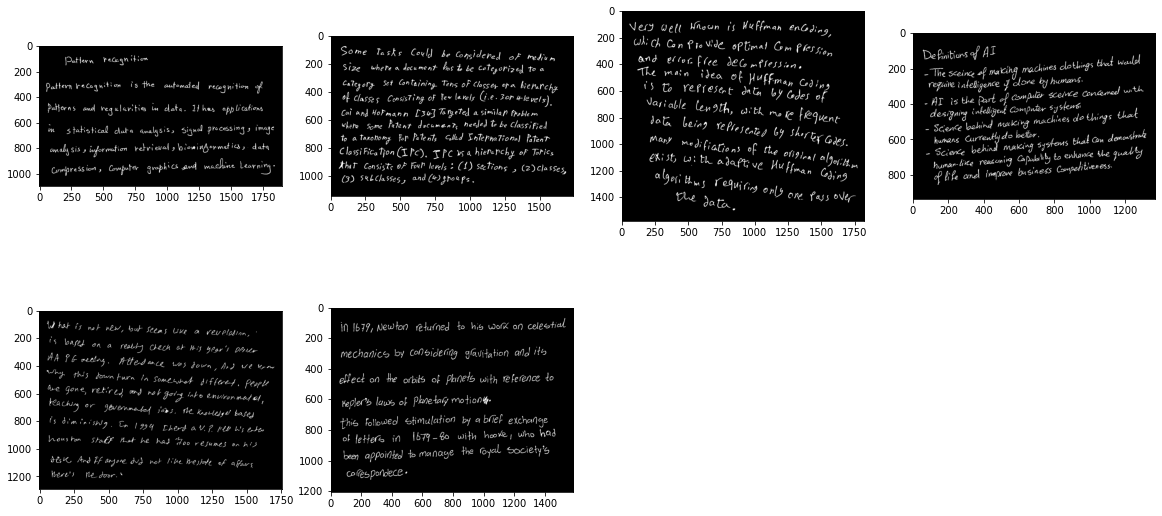

In [16]:
# Preview the test images after preprocessing.
preview(map(pre, TST_IMAGES))

In [3]:
%%time
# GLCM features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(glcm(image_path))

save_feature('glcm', cmp_features)

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 13.4 s, sys: 216 ms, total: 13.6 s
Wall time: 13.6 s


In [3]:
features = load_feature('glcm')
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 76.01928374655648
female_predict% = 23.980716253443532


(68.24657534246575, 76.12068965517244)

In [8]:
%%time
# LBP features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(ojalat_lbp(image_path))

save_feature('lbp', cmp_features)

The following 112 features were removed because they are not discriminative:
[  3   5   7   9  11  13  15  17  20  21  24  25  28  29  32  33  37  41
  45  49  50  53  54  57  58  61  62  65  67  69  71  73  75  77  79  81
  84  85  88  89  92  93  96  97 101 105 109 113 114 117 118 121 122 125
 126 129 131 133 135 137 139 141 143 145 148 149 152 153 156 157 160 161
 165 169 173 177 178 181 182 185 186 189 190 193 195 197 199 201 203 205
 207 209 212 213 216 217 220 221 224 225 226 228 229 230 232 233 234 236
 237 238 240 241]
CPU times: user 4min 15s, sys: 3.17 s, total: 4min 18s
Wall time: 4min 18s


In [4]:
features = load_feature('lbp')
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 64.45179063360884
female_predict% = 35.548209366391184


(76.34246575342468, 97.64482758620682)

In [5]:
%%time
# HoG features.
cmp_features = []

# Get the best resize ratio.
resize_w, resize_h = get_avg_image_shape()
# Upscale the resize parameters so not to lose any resolution.
resize_factor = int(resize_w * 1.15), int(resize_h * 1.15)

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(hog(image_path, resize_factor))

# Run PCA first to shrink the number of features.
cmp_features = pca(cmp_features)
save_feature('hog', cmp_features)

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 3min 10s, sys: 11.8 s, total: 3min 22s
Wall time: 2min 50s


In [19]:
features = load_feature('hog')
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 71.19559228650144
female_predict% = 28.804407713498627


(63.78082191780823, 100.0)

In [4]:
%%time
# Chain Code features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(freeman_cc_hists(image_path))

save_feature('chain_codes_and_pairs', cmp_features)

The following 12 features were removed because they are not discriminative:
[11 12 21 29 30 39 47 48 49 57 58 67]
CPU times: user 11min 28s, sys: 1.22 s, total: 11min 29s
Wall time: 11min 23s


In [7]:
features = load_feature('chain_codes_and_pairs')
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 64.54269972451792
female_predict% = 35.457300275482105


(69.93150684931504, 98.46896551724124)

In [8]:
%%time
# Distribution of segment slopes and distribution of curvature features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(slopes_and_curves(image_path))

save_feature('slopes_and_curves', cmp_features)

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 2min 33s, sys: 1.71 s, total: 2min 34s
Wall time: 2min 28s


In [17]:
features = load_feature('slopes_and_curves')
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 65.1818181818182
female_predict% = 34.81818181818182


(67.69863013698631, 94.27931034482765)

In [12]:
features = combine_features(
    load_feature('chain_codes_and_pairs'),
    load_feature('slopes_and_curves'),
    load_feature('lbp'),
    load_feature('glcm'),
    #load_feature('hog'),
)

svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 64.51515151515153
female_predict% = 35.48484848484848


(76.16438356164386, 97.74827586206885)

In [20]:
%%time
# Hinge features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    cmp_features.append(hinge(image_path))

save_feature('hinge', cmp_features)

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 1min 40s, sys: 405 ms, total: 1min 40s
Wall time: 1min 37s


In [32]:
features = load_feature('hinge')
features = pca(features)
svm_test(features, LABELS, C=10, kernel='rbf')

male_predict% = 64.74380165289259
female_predict% = 35.25619834710744


(78.65753424657535, 100.0)

In [ ]:
%%time
# COLD features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    print(1)
    cmp_features.append(cold(image_path))

save_feature('cold', cmp_features)

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10


In [23]:
features = load_feature('cold')
svm_test(features, LABELS, C=10, kernel='rbf', times=100)

[[0.         0.         0.44772233 ... 0.31601153 0.27181006 1.        ]
 [0.         0.         0.         ... 0.31057723 0.2846477  1.        ]
 [0.         0.         0.         ... 0.31730981 0.31285977 1.        ]
 ...
 [0.         0.         0.3129815  ... 0.32384866 0.32955522 0.        ]
 [1.         0.98747475 0.81273577 ... 0.31626278 0.28349424 0.        ]
 [0.         0.15777709 0.1558291  ... 0.31643157 0.30740107 0.        ]]
male_predict% = 49.899999999999984
female_predict% = 50.10000000000001


(57.5, 100.0)